#Backpropagation en PyTorch

In [ ]:
import torch

# Definimos x como un tensor que requiere gradiente
x = torch.tensor(1.0, requires_grad=True)

# Definimos y y z
y = x + 3
z = 2 * y**2 + 1

# Calculamos la derivada dz/dx
z.backward()

# Imprimimos el resultado
print("dz/dx en x=1:", x.grad.item())


dz/dx en x=1: 16.0


##Librerías necesarias

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install graphviz

import math               # Funciones matemáticas básicas (sin vectores)
import numpy as np        # Arrays, operaciones vectoriales y matriciales
import matplotlib.pyplot as plt  # Graficar
# Mostrar las gráficas dentro del notebook
%matplotlib inline

##Funciones para dibujar la **digráfica de operaciones**

In [ ]:
from graphviz import Digraph

def rastrear(raiz):
    # Construye una lista (que luego convertiremos a tupla) de todos los nodos y aristas
    nodos, aristas = [], []

    def construir(nodo):
        if nodo not in nodos:  # evitamos repetir nodos
            nodos.append(nodo)
            for padre in nodo.x_entradas:          # entradas son los nodos padres
                aristas.append((padre, nodo))      # guardamos la arista de padre → nodo
                construir(padre)

    construir(raiz)
    return tuple(nodos), tuple(aristas)

def digrafica(raiz):
    # Crear un grafo de Graphviz en formato SVG, de izquierda a derecha
    grafo = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodos, aristas = rastrear(raiz)

    for nodo in nodos:
        id_unico = str(id(nodo))  # identificador único
        grafo.node(
            name=id_unico,
            label="{ %s | valor %.4f | gradiente %.4f }" % (nodo.etiqueta, nodo.valor, nodo.grad),
            shape='record'
        )

        if nodo.operacion:
            grafo.node(name=id_unico + nodo.operacion, label=nodo.operacion)
            grafo.edge(id_unico + nodo.operacion, id_unico)

    for padre, hijo in aristas:
        grafo.edge(str(id(padre)), str(id(hijo)) + hijo.operacion)

    return grafo


##Clase para representar valores y calcular gradiente

In [ ]:
class Valor:

    def __init__(self, valor, x_entradas=(), operacion='', etiqueta=''):
        self.valor = valor                 # valor numérico de este nodo
        self.grad = 0.0 # dz/dvariable                   # derivada asociada
        self.retropropagar = lambda: None  # función para propagar gradiente hacia atrás
        self.x_entradas = x_entradas       # entradas que definen a este valor
        self.operacion = operacion         # operación que generó este nodo
        self.etiqueta = etiqueta           # nombre opcional

    def __repr__(self):
        return f"Valor(dato={self.valor})"

    # x1 + x2
    def __add__(self, x2):
      x1 = self
      res_suma = x1.valor + x2.valor
      x_entradas = (x1,x2)
      operacion = "+"
      etiqueta = ''
      y = Valor(res_suma,x_entradas,operacion,etiqueta)

      def retro():
        # z = f(y)
        # y = x1 + x2
        # dz/dx1 = (dz/dy)(dy/dx1)
        #
        dz_dy = y.grad # dz/dy
        dy_dx1 = 1
        dz_dx1 = dz_dy * dy_dx1
        x1.grad = dz_dx1 #dz/dx1

        # y = x1+x2
        #dz/dx2 = (dz/dy)(dy/dx2)
        #dz_dy = y.grad
        dy_dx2 = 1
        dz_dx2 = dz_dy * dy_dx2
        x2.grad = dz_dx2

      y.retropropagar = retro

      return y

    # x1*x2
    def __mul__(self, x2):
      x1 = self
      res_mult = x1.valor * x2.valor
      x_entradas = (x1,x2)
      operacion = "*"
      etiqueta = ''
      y = Valor(res_mult,x_entradas,operacion,etiqueta)

      def retro():
          # y = x1*x2
          # dz/dx1 = (dz/dy)(dy/dx1)
          dz_dy = y.grad
          dy_dx1 = x2.valor
          dz_dx1 = dz_dy * dy_dx1
          x1.grad = dz_dx1

          # dz/dx2 = (dz/dy)(dy/dx2)
          #dz_dy = y.grad
          dy_dx2 = x1.valor
          dz_dx2 = dz_dy * dy_dx2
          x2.grad = dz_dx2

      y.retropropagar = retro

      return y




##Ejemplo de operaciones y derivadas

Valor(dato=20.0)


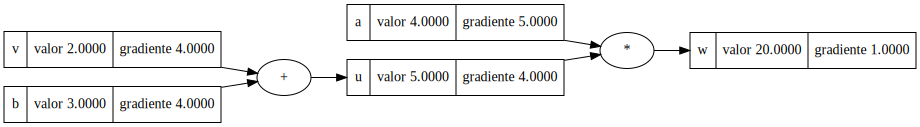

In [ ]:
v = Valor(2.0, etiqueta='v')
b = Valor(3.0, etiqueta='b')
u = v+b
u.etiqueta = 'u'
a = Valor(4.0, etiqueta='a')
w = a*u
w.etiqueta = 'w'

print(w)
w.grad = 1 #dz/w, como z=w dw/dw=1
w.retropropagar()
u.retropropagar()
digrafica(w)
